In [ ]:
!pip install catboost

     |████████████████████████████████| 66.1MB 46kB/s 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef

from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold,GroupKFold
from sklearn.utils import resample
from catboost import CatBoostClassifier
from sklearn.preprocessing import KBinsDiscretizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Analysis

In [ ]:
train = pd.read_csv("/content/drive/My Drive/JH_CrossSellPrediction/train.csv")
test = pd.read_csv("/content/drive/My Drive/JH_CrossSellPrediction/test.csv")
submission = pd.read_csv("/content/drive/My Drive/JH_CrossSellPrediction/sample_submission_iA3afxn.csv")

## Check null and basic class counts and so on

In [ ]:
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [ ]:
test.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
dtype: int64

In [ ]:
train['Response'].value_counts()

0    334399
1     46710
Name: Response, dtype: int64

In [ ]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# Basic normalization, ohe and label encoding

In [ ]:
## We will label encode for variable Vehicle_Age, Vehicle Damage
## OHE for Male /Female (as it is not ordinal)
## Age, AnnualPremium,Vintage standardization (z value)

In [ ]:
def combine_df(train,test):
  train['is_train'] = 1
  test['is_train'] = 0
  return pd.concat([train,test],axis=0)

In [ ]:
combined = combine_df(train,test)

In [ ]:
combined['Vehicle_Age'].value_counts()

1-2 Year     267015
< 1 Year     219805
> 2 Years     21326
Name: Vehicle_Age, dtype: int64

In [ ]:
combined['Vehicle_Damage'].value_counts()

Yes    256248
No     251898
Name: Vehicle_Damage, dtype: int64

In [ ]:
vehicle_age = {"< 1 Year": 1,
               "1-2 Year": 2,
               "> 2 Years":3}
vehicle_damage = {"Yes":1,"No":0}

combined['Vehicle_Age'] = combined['Vehicle_Age'].map(vehicle_age)
combined['Vehicle_Damage'] = combined['Vehicle_Damage'].map(vehicle_damage)

In [ ]:
combined['Gender'].value_counts()

Male      274325
Female    233821
Name: Gender, dtype: int64

In [ ]:
combined = pd.get_dummies(combined,columns=['Gender'])

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1
4,5,29,1,41.0,1,1,0,27496.0,152.0,39,0.0,1,1,0


In [ ]:
def z_score(x, x_mean, x_std):
  return (x - x_mean) / x_std

In [ ]:
# Age_mean = combined['Age'].mean()
# Age_std = combined['Age'].std()
# combined['Age'] = combined['Age'].apply(z_score, args=(Age_mean, Age_std))

In [ ]:
# Premium_mean = combined['Annual_Premium'].mean()
# Premium_std = combined['Annual_Premium'].std()
# combined['Annual_Premium'] = combined['Annual_Premium'].apply(z_score, args=(Premium_mean, Premium_std))

In [ ]:
# Vintage_mean = combined['Vintage'].mean()
# Vintage_std = combined['Vintage'].std()
# combined['Vintage'] = combined['Vintage'].apply(z_score, args=(Vintage_mean, Vintage_std))

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1
4,5,29,1,41.0,1,1,0,27496.0,152.0,39,0.0,1,1,0


In [ ]:
combined.shape

(508146, 14)

In [ ]:
combined.drop_duplicates().shape

(508146, 14)

# Feature Engineering

In [ ]:
combined['mean_Age_per_region_code']=combined.groupby(['Region_Code'])['Age'].transform('mean')
combined['sum_Age_per_region_code']=combined.groupby(['Region_Code'])['Age'].transform('sum')
combined['max_Age_per_region_code']=combined.groupby(['Region_Code'])['Age'].transform('max')
combined['min_Age_per_region_code']=combined.groupby(['Region_Code'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_region_code']=combined.groupby(['Region_Code'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_region_code']=combined.groupby(['Region_Code'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_region_code']=combined.groupby(['Region_Code'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_region_code']=combined.groupby(['Region_Code'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_region_code']=combined.groupby(['Region_Code'])['Vintage'].transform('mean')
combined['sum_Vintage_per_region_code']=combined.groupby(['Region_Code'])['Vintage'].transform('sum')
combined['max_Vintage_per_region_code']=combined.groupby(['Region_Code'])['Vintage'].transform('max')
combined['min_Vintage_per_region_code']=combined.groupby(['Region_Code'])['Vintage'].transform('min')

In [ ]:
combined['mean_Age_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Age'].transform('mean')
combined['sum_Age_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Age'].transform('sum')
combined['max_Age_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Age'].transform('max')
combined['min_Age_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Vintage'].transform('mean')
combined['sum_Vintage_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Vintage'].transform('sum')
combined['max_Vintage_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Vintage'].transform('max')
combined['min_Vintage_per_channel']=combined.groupby(['Policy_Sales_Channel'])['Vintage'].transform('min')

In [ ]:
combined['mean_Age_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Age'].transform('mean')
combined['sum_Age_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Age'].transform('sum')
combined['max_Age_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Age'].transform('max')
combined['min_Age_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Vintage'].transform('mean')
combined['sum_Vintage_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Vintage'].transform('sum')
combined['max_Vintage_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Vintage'].transform('max')
combined['min_Vintage_per_vehicle_age']=combined.groupby(['Vehicle_Age'])['Vintage'].transform('min')

In [ ]:
combined['mean_Age_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Age'].transform('mean')
combined['sum_Age_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Age'].transform('sum')
combined['max_Age_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Age'].transform('max')
combined['min_Age_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Vintage'].transform('mean')
combined['sum_Vintage_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Vintage'].transform('sum')
combined['max_Vintage_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Vintage'].transform('max')
combined['min_Vintage_per_vehicle_damage']=combined.groupby(['Vehicle_Damage'])['Vintage'].transform('min')

In [ ]:
combined['mean_Age_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Age'].transform('mean')
combined['sum_Age_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Age'].transform('sum')
combined['max_Age_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Age'].transform('max')
combined['min_Age_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Vintage'].transform('mean')
combined['sum_Vintage_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Vintage'].transform('sum')
combined['max_Vintage_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Vintage'].transform('max')
combined['min_Vintage_per_Previously_Insured']=combined.groupby(['Previously_Insured'])['Vintage'].transform('min')

In [ ]:
combined['mean_Age_per_Driving_License']=combined.groupby(['Driving_License'])['Age'].transform('mean')
combined['sum_Age_per_Driving_License']=combined.groupby(['Driving_License'])['Age'].transform('sum')
combined['max_Age_per_Driving_License']=combined.groupby(['Driving_License'])['Age'].transform('max')
combined['min_Age_per_Driving_License']=combined.groupby(['Driving_License'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_Driving_License']=combined.groupby(['Driving_License'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_Driving_License']=combined.groupby(['Driving_License'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_Driving_License']=combined.groupby(['Driving_License'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_Driving_License']=combined.groupby(['Driving_License'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_Driving_License']=combined.groupby(['Driving_License'])['Vintage'].transform('mean')
combined['sum_Vintage_per_Driving_License']=combined.groupby(['Driving_License'])['Vintage'].transform('sum')
combined['max_Vintage_per_Driving_License']=combined.groupby(['Driving_License'])['Vintage'].transform('max')
combined['min_Vintage_per_Driving_License']=combined.groupby(['Driving_License'])['Vintage'].transform('min')

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,mean_Vintage_per_vehicle_age,sum_Vintage_per_vehicle_age,max_Vintage_per_vehicle_age,min_Vintage_per_vehicle_age,mean_Age_per_vehicle_damage,sum_Age_per_vehicle_damage,max_Age_per_vehicle_damage,min_Age_per_vehicle_damage,mean_Annual_Premium_per_vehicle_damage,sum_Annual_Premium_per_vehicle_damage,max_Annual_Premium_per_vehicle_damage,min_Annual_Premium_per_vehicle_damage,mean_Vintage_per_vehicle_damage,sum_Vintage_per_vehicle_damage,max_Vintage_per_vehicle_damage,min_Vintage_per_vehicle_damage,mean_Age_per_Previously_Insured,sum_Age_per_Previously_Insured,max_Age_per_Previously_Insured,min_Age_per_Previously_Insured,mean_Annual_Premium_per_Previously_Insured,sum_Annual_Premium_per_Previously_Insured,max_Annual_Premium_per_Previously_Insured,min_Annual_Premium_per_Previously_Insured,mean_Vintage_per_Previously_Insured,sum_Vintage_per_Previously_Insured,max_Vintage_per_Previously_Insured,min_Vintage_per_Previously_Insured,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,154.740739,3300001,299,10,42.932081,11001260,85,20,30716.024137,7.870920e+09,540165.0,2630.0,154.250671,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,154.193603,41172005,299,10,34.613534,8719080,85,20,30390.091791,7.655203e+09,540165.0,2630.0,154.431119,38900890,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,154.740739,3300001,299,10,42.932081,11001260,85,20,30716.024137,7.870920e+09,540165.0,2630.0,154.250671,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637

In [ ]:
combined['Vintage'].describe()

count    508146.000000
mean        154.340123
std          83.668793
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

In [ ]:
combined['Premium_by_age'] = combined['Annual_Premium'] / combined['Age']

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,sum_Vintage_per_vehicle_age,max_Vintage_per_vehicle_age,min_Vintage_per_vehicle_age,mean_Age_per_vehicle_damage,sum_Age_per_vehicle_damage,max_Age_per_vehicle_damage,min_Age_per_vehicle_damage,mean_Annual_Premium_per_vehicle_damage,sum_Annual_Premium_per_vehicle_damage,max_Annual_Premium_per_vehicle_damage,min_Annual_Premium_per_vehicle_damage,mean_Vintage_per_vehicle_damage,sum_Vintage_per_vehicle_damage,max_Vintage_per_vehicle_damage,min_Vintage_per_vehicle_damage,mean_Age_per_Previously_Insured,sum_Age_per_Previously_Insured,max_Age_per_Previously_Insured,min_Age_per_Previously_Insured,mean_Annual_Premium_per_Previously_Insured,sum_Annual_Premium_per_Previously_Insured,max_Annual_Premium_per_Previously_Insured,min_Annual_Premium_per_Previously_Insured,mean_Vintage_per_Previously_Insured,sum_Vintage_per_Previously_Insured,max_Vintage_per_Previously_Insured,min_Vintage_per_Previously_Insured,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,3300001,299,10,42.932081,11001260,85,20,30716.024137,7.870920e+09,540165.0,2630.0,154.250671,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,919.409091
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,41172005,299,10,34.613534,8719080,85,20,30390.091791,7.655203e+09,540165.0,2630.0,154.431119,38900890,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,441.263158
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,3300001,299,10,42.932081,11001260,85,20,30716.024137,7.870920e+09,540165.0,2630.0,154.250671,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,814.765957
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637.0,2630.0,154.

In [ ]:
combined['mean_Age_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Age'].transform('mean')
combined['sum_Age_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Age'].transform('sum')
combined['max_Age_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Age'].transform('max')
combined['min_Age_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Vintage'].transform('mean')
combined['sum_Vintage_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Vintage'].transform('sum')
combined['max_Vintage_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Vintage'].transform('max')
combined['min_Vintage_per_insured_damage']=combined.groupby(['Previously_Insured','Vehicle_Damage'])['Vintage'].transform('min')

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,sum_Vintage_per_vehicle_damage,max_Vintage_per_vehicle_damage,min_Vintage_per_vehicle_damage,mean_Age_per_Previously_Insured,sum_Age_per_Previously_Insured,max_Age_per_Previously_Insured,min_Age_per_Previously_Insured,mean_Annual_Premium_per_Previously_Insured,sum_Annual_Premium_per_Previously_Insured,max_Annual_Premium_per_Previously_Insured,min_Annual_Premium_per_Previously_Insured,mean_Vintage_per_Previously_Insured,sum_Vintage_per_Previously_Insured,max_Vintage_per_Previously_Insured,min_Vintage_per_Previously_Insured,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,38900890,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,39526426,299,10,42.454976,11678345,85,20,30479.076437,8.384062e+09,540165.0,2630.0,154.211978,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637.0,2

In [ ]:
combined['mean_Age_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Age'].transform('mean')
combined['sum_Age_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Age'].transform('sum')
combined['max_Age_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Age'].transform('max')
combined['min_Age_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Age'].transform('min')

In [ ]:
combined['mean_Annual_Premium_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Annual_Premium'].transform('mean')
combined['sum_Annual_Premium_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Annual_Premium'].transform('sum')
combined['max_Annual_Premium_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Annual_Premium'].transform('max')
combined['min_Annual_Premium_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Annual_Premium'].transform('min')

In [ ]:
combined['mean_Vintage_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Vintage'].transform('mean')
combined['sum_Vintage_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Vintage'].transform('sum')
combined['max_Vintage_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Vintage'].transform('max')
combined['min_Vintage_per_insured_damage_license']=combined.groupby(['Previously_Insured','Vehicle_Damage','Driving_License'])['Vintage'].transform('min')

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,sum_Vintage_per_Previously_Insured,max_Vintage_per_Previously_Insured,min_Vintage_per_Previously_Insured,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10,37.495621,1198810,84,20,27368.564682,8.750278e+08,337573.0,2630.0,154.385744,4936021,299,10
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,42420014,299,10,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,3

In [ ]:
combined['Driving_License_per_Region_code'] = combined.groupby(['Region_Code'])['Driving_License'].transform("sum")

In [ ]:
combined['PreviouslyInsured_per_Region_code'] = combined.groupby(['Region_Code'])['Previously_Insured'].transform("sum")

In [ ]:
combined['VehicleDamage_per_Region_code'] = combined.groupby(['Region_Code'])['Vehicle_Damage'].transform("sum")

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,mean_Age_per_Driving_License,sum_Age_per_Driving_License,max_Age_per_Driving_License,min_Age_per_Driving_License,mean_Annual_Premium_per_Driving_License,sum_Annual_Premium_per_Driving_License,max_Annual_Premium_per_Driving_License,min_Annual_Premium_per_Driving_License,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license,Driving_License_per_Region_code,PreviouslyInsured_per_Region_code,VehicleDamage_per_Region_code
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10,37.495621,1198810,84,20,27368.564682,8.750278e+08,337573.0,2630.0,154.385744,4936021,299,10,12328,6000,5937
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,38.752254,19651152,85,20,30545.029002,1.548929e+10,540165.0,2630.0,154.336886,78263772,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.2

In [ ]:
combined['channel_users'] = combined.groupby(['Policy_Sales_Channel'])['Previously_Insured'].transform('sum')
combined['channel_effort'] = combined.groupby(['Policy_Sales_Channel'])['id'].transform('count')

In [ ]:
hist, bin_edg = np.histogram(combined['Age'].values,bins='sturges')
Bin = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='kmeans')
combined['Age_group'] = Bin.fit_transform(combined['Age'].values.reshape(-1, 1))

In [ ]:
combined['Age_grp_premium'] = combined.groupby(['Age_group'])['Annual_Premium'].transform('mean')
combined['Age_grp_premium1'] = combined.groupby(['Age_group'])['Annual_Premium'].transform('std')

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
cluster = combined.drop(['id','Response','is_train'],axis=1).copy()
kmeanModel = KMeans(n_clusters=7)
preds = kmeanModel.fit_predict(cluster)

In [ ]:
combined['customer_seg'] = preds

In [ ]:
combined['Age_customer_seg'] = combined.groupby(['customer_seg'])['Age'].transform('mean')
combined['Revenue_customer_seg'] = combined.groupby(['customer_seg'])['Annual_Premium'].transform('mean')

In [ ]:
combined.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,mean_Vintage_per_Driving_License,sum_Vintage_per_Driving_License,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license,Driving_License_per_Region_code,PreviouslyInsured_per_Region_code,VehicleDamage_per_Region_code,channel_users,channel_effort,Age_group,Age_grp_premium,Age_grp_premium1,customer_seg,Age_customer_seg,Revenue_customer_seg
0,1,44,1,28.0,0,3,1,40454.0,26.0,217,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,154.336886,78263772,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,32235,106594,7.0,31182.334555,17803.080293,4,55.114958,35654.103340
1,2,76,1,3.0,0,2,0,33536.0,26.0,183,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,154.336886,78263772,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10,37.495621,1198810,84,20,27368.564682,8.750278e+08,337573.0,2630.0,154.385744,4936021,299,10,12328,6000,5937,32235,106594,17.0,34877.882420,19182.468086,2,38.580845,27488.904116
2,3,47,1,28.0,0,3,1,38294.0,26.0,27,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,154.336886,78263772,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,32235,106594,8.0,31531.632683,18610.090269,4,55.114958,35654.103340
3,4,21,1,11.0,1,1,0,28619.0,152.0,203,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637.0,2630.0,154.520360,1904927,299,10,26.211884,4705636,80,20,30898.685511,5.547025e+09,495106

In [ ]:
combined['Vintage'].describe()

count    508146.000000
mean        154.340123
std          83.668793
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

In [ ]:
combined['Vintage'] // 7

0         31
1         26
2          3
3         29
4          5
          ..
127032     8
127033    23
127034    10
127035    37
127036    33
Name: Vintage, Length: 508146, dtype: int64

In [ ]:
combined['Monthly_Premium'] = combined['Annual_Premium'] / 12
combined['Vintage_weeks'] = combined['Vintage'] // 7

## Normalization

In [ ]:
Age_mean = combined['Age'].mean()
Age_std = combined['Age'].std()
combined['Age'] = combined['Age'].apply(z_score, args=(Age_mean, Age_std))

In [ ]:
Premium_mean = combined['Annual_Premium'].mean()
Premium_std = combined['Annual_Premium'].std()
combined['Annual_Premium'] = combined['Annual_Premium'].apply(z_score, args=(Premium_mean, Premium_std))

In [ ]:
Vintage_mean = combined['Vintage'].mean()
Vintage_std = combined['Vintage'].std()
combined['Vintage'] = combined['Vintage'].apply(z_score, args=(Vintage_mean, Vintage_std))

# Model

## Helpful method for accuracy detection

In [ ]:
def print_score(m):
  all_metrics = [m.score(X_train,y_train),m.score(X_test,y_test), m.score(X_valid, y_valid)]
  if hasattr(m,"oob_score"):
    all_metrics.append(m.oob_score)
  return all_metrics 


def evaluate_model(y_true, y_pred):
    print('confusion matrix')
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm.T)
    cm_df.index.name = 'Predicted'
    cm_df.columns.name = 'True'
    print(cm_df)
    print('classification report')
    print(classification_report(y_true,y_pred))
    print('accuracy score')
    print(accuracy_score(y_true, y_pred))

## Splitting into train and test

In [ ]:
combined.columns

Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage',
       ...
       'channel_users', 'channel_effort', 'Age_group', 'Age_grp_premium',
       'Age_grp_premium1', 'customer_seg', 'Age_customer_seg',
       'Revenue_customer_seg', 'Monthly_Premium', 'Vintage_weeks'],
      dtype='object', length=124)

In [ ]:
train = combined[combined['is_train'] == 1]
test = combined[combined['is_train'] == 0]

In [ ]:
train.head()

,id,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,is_train,Gender_Female,Gender_Male,mean_Age_per_region_code,sum_Age_per_region_code,max_Age_per_region_code,min_Age_per_region_code,mean_Annual_Premium_per_region_code,sum_Annual_Premium_per_region_code,max_Annual_Premium_per_region_code,min_Annual_Premium_per_region_code,mean_Vintage_per_region_code,sum_Vintage_per_region_code,max_Vintage_per_region_code,min_Vintage_per_region_code,mean_Age_per_channel,sum_Age_per_channel,max_Age_per_channel,min_Age_per_channel,mean_Annual_Premium_per_channel,sum_Annual_Premium_per_channel,max_Annual_Premium_per_channel,min_Annual_Premium_per_channel,mean_Vintage_per_channel,sum_Vintage_per_channel,max_Vintage_per_channel,min_Vintage_per_channel,mean_Age_per_vehicle_age,sum_Age_per_vehicle_age,...,max_Vintage_per_Driving_License,min_Vintage_per_Driving_License,Premium_by_age,mean_Age_per_insured_damage,sum_Age_per_insured_damage,max_Age_per_insured_damage,min_Age_per_insured_damage,mean_Annual_Premium_per_insured_damage,sum_Annual_Premium_per_insured_damage,max_Annual_Premium_per_insured_damage,min_Annual_Premium_per_insured_damage,mean_Vintage_per_insured_damage,sum_Vintage_per_insured_damage,max_Vintage_per_insured_damage,min_Vintage_per_insured_damage,mean_Age_per_insured_damage_license,sum_Age_per_insured_damage_license,max_Age_per_insured_damage_license,min_Age_per_insured_damage_license,mean_Annual_Premium_per_insured_damage_license,sum_Annual_Premium_per_insured_damage_license,max_Annual_Premium_per_insured_damage_license,min_Annual_Premium_per_insured_damage_license,mean_Vintage_per_insured_damage_license,sum_Vintage_per_insured_damage_license,max_Vintage_per_insured_damage_license,min_Vintage_per_insured_damage_license,Driving_License_per_Region_code,PreviouslyInsured_per_Region_code,VehicleDamage_per_Region_code,channel_users,channel_effort,Age_group,Age_grp_premium,Age_grp_premium1,customer_seg,Age_customer_seg,Revenue_customer_seg,Monthly_Premium,Vintage_weeks
0,1,0.334937,1,28.0,0,3,1,0.577348,26.0,0.748904,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,299,10,919.409091,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,32235,106594,7.0,31182.334555,17803.080293,6,55.114958,35654.103340,3371.166667,31
1,2,2.399430,1,3.0,0,2,0,0.173886,26.0,0.342540,0.0,1,0,1,36.980970,456678,82,20,24465.445218,3.021238e+08,424578.0,2630.0,154.864442,1912421,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,49.017962,13088531,...,299,10,441.263158,37.568585,1203998,84,20,27389.917904,8.777921e+08,337573.0,2630.0,154.398402,4948160,299,10,37.495621,1198810,84,20,27368.564682,8.750278e+08,337573.0,2630.0,154.385744,4936021,299,10,12328,6000,5937,32235,106594,17.0,34877.882420,19182.468086,3,38.580845,27488.904116,2794.666667,26
2,3,0.528483,1,28.0,0,3,1,0.451376,26.0,-1.521955,1.0,1,0,1,46.223536,6560830,85,20,38649.878763,5.485848e+09,540165.0,2630.0,154.266618,21896141,299,10,50.630664,5396925,85,20,33639.830863,3.585804e+09,540165.0,2630.0,154.405070,16458654,299,10,55.111085,1175299,...,299,10,814.765957,43.099342,10474347,85,20,30886.442472,7.506270e+09,540165.0,2630.0,154.187394,37471854,299,10,43.038895,10431380,85,20,30874.077567,7.482981e+09,540165.0,2630.0,154.181598,37369148,299,10,141486,44166,93767,32235,106594,8.0,31531.632683,18610.090269,6,55.114958,35654.103340,3191.166667,3
3,4,-1.148917,1,11.0,1,1,0,-0.112877,152.0,0.581577,0.0,1,0,1,34.235480,422055,82,20,27655.183160,3.409331e+08,193637.0,2630.0,154.520360,1904927,299,10,26.211884,4705636,80,20,30898.685511,5.547025e+09,49510

In [ ]:
train.columns

Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage',
       ...
       'channel_users', 'channel_effort', 'Age_group', 'Age_grp_premium',
       'Age_grp_premium1', 'customer_seg', 'Age_customer_seg',
       'Revenue_customer_seg', 'Monthly_Premium', 'Vintage_weeks'],
      dtype='object', length=124)

## Upsample

In [ ]:
combined['Response'].value_counts()

0.0    334399
1.0     46710
Name: Response, dtype: int64

In [ ]:
df_majority = combined[combined.Response==0.0]
df_minority = combined[combined.Response==1.0]
 
# downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=46710,    # to match minority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_minority, df_majority_downsampled])
 

In [ ]:
df_downsampled['Response'].value_counts()

0.0    46710
1.0    46710
Name: Response, dtype: int64

In [ ]:
train = df_downsampled.copy()

## Split into X and y

### Single class model 

In [ ]:
single_class = train[train['Response'] == 1.0]
X = single_class.drop(['id','Response','is_train'],axis=1)
y = single_class['Response']

In [ ]:
X_test = test.drop(['id','Response','is_train'],axis=1)

In [ ]:
model = lgb.LGBMClassifier(n_estimators=200)
model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=200, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
y_pred_test = model.predict_proba()

In [ ]:
y_pred_test

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
B = np.where(y_pred_test > 0.5, 1, 0)

In [ ]:
B.shape

(127037, 2)

## Split

In [ ]:
X = train.drop(['id','Response','is_train'],axis=1)
y = train['Response']

X_test = test.drop(['id','Response','is_train'],axis=1)
y_test = test['Response']

In [ ]:
# X = train[['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
#        'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
#        'Policy_Sales_Channel', 'Vintage',
#       'Gender_Female', 'Gender_Male']]
# y = train['Response']

# X_test = test[['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
#        'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
#        'Policy_Sales_Channel', 'Vintage',
#       'Gender_Female', 'Gender_Male']]
# y_test = test['Response']
 

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=88)

## LightGBM

In [ ]:
estimators = [500]
for estimator in estimators:
  model = lgb.LGBMClassifier(random_state=0, n_estimators=estimator, 
                                      learning_rate=0.1, num_leaves=31,
                                      is_unbalance=True)
  model.fit(X_train,y_train)

  print("Estimators ===>{}".format(estimator))
  y_pred = model.predict(X_valid)
  evaluate_model(y_valid,y_pred)
  print("===============================================")

Estimators ===>500
confusion matrix
True           0     1
Predicted             
0          46361   937
1          20507  8417
classification report
              precision    recall  f1-score   support

         0.0       0.98      0.69      0.81     66868
         1.0       0.29      0.90      0.44      9354

    accuracy                           0.72     76222
   macro avg       0.64      0.80      0.63     76222
weighted avg       0.90      0.72      0.77     76222

accuracy score
0.7186639028102123


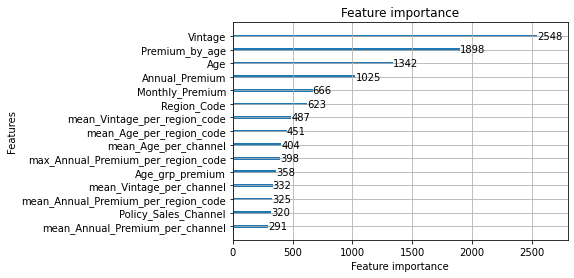

In [ ]:
lgb.plot_importance(model,max_num_features = 15)

In [ ]:
model = lgb.LGBMClassifier(random_state=0, n_estimators=200, 
                          learning_rate=0.1, num_leaves=31,
                          is_unbalance=True)
model.fit(X,y)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=True, learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=200, n_jobs=-1, num_leaves=31,
               objective=None, random_state=0, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [ ]:
y_pred_test = model.predict_proba(X_test)

In [ ]:
X.shape

(381109, 121)

In [ ]:
submission['Response_pred'] = y_pred_test[:,1]

In [ ]:
submission.shape

(127037, 3)

In [ ]:
submission.drop("Response",axis=1,inplace=True)

In [ ]:
submission.head()

,id,Response_pred
0,381110,0.000285
1,381111,0.786928
2,381112,0.754452
3,381113,0.040824
4,381114,0.000214


In [ ]:
submission.columns = ['id','Response']

In [ ]:
submission.to_csv("lgb_new.csv",index=False)

## Stack blend and undersample

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier, XGBRFClassifier
!pip install vecstack
from vecstack import StackingTransformer
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score

  Created wheel for vecstack: filename=vecstack-0.4.0-cp36-none-any.whl size=19880 sha256=f4d641a46ac0e2ec555ec00aee3678e08df45c7c2c634ee50791d58091ba27f7
  Stored in directory: /root/.cache/pip/wheels/5f/bb/4e/f6488433d53bc0684673d6845e5bf11a25240577c8151c140e
Successfully built vecstack


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
train1 = train.copy()
test1 = test.copy()

In [ ]:
test1.shape

(127037, 124)

In [ ]:
def final_submission(X_train, Y, X_test):
    # Define base estimators for stacking
    estimators = [('lgbm', LGBMClassifier(random_state=0, n_estimators=500, 
                                      learning_rate=0.1, num_leaves=31,
                                      is_unbalance=True)),
              # ('rf', RandomForestClassifier(random_state=0, max_depth=10, 
              #                               class_weight={0:0.12, 1:0.88}, 
              #                               n_estimators=500, max_features=None, n_jobs=4)),
              ('cat', CatBoostClassifier(scale_pos_weight=6, verbose=100,
                                                  early_stopping_rounds=100,iterations=500))]
    # Perform stacking
    stack = StackingTransformer(estimators, regression=False, verbose=2, needs_proba=True, stratified=True, shuffle=True)
    stack = stack.fit(X_train, Y)

    # Get the stacked features
    S_train = stack.transform(X_train)
    S_test = stack.transform(X_test)
    # Also take the weighted average of the stacked features as another feature
    S_train_av, S_test_av = np.zeros((len(S_train), 2), dtype=np.float32), np.zeros((len(S_test), 2), dtype=np.float32)
    for index, vals in enumerate(S_train):
        S_train_av[index, 0] = (vals[0]*0.7) + (vals[2]*0.3)
        S_train_av[index, 1] = (vals[1]*0.7) + (vals[3]*0.3)
    for index, vals in enumerate(S_test):
        S_test_av[index, 0] = (vals[0]*0.7) + (vals[2]*0.3)
        S_test_av[index, 1] = (vals[1]*0.7) + (vals[3]*0.3)

    # Define the final estimator
    model = XGBClassifier(random_state=0, n_jobs=4, max_depth=4, scale_pos_weight=2.5, n_estimators=200, learning_rate=0.1, gamma=1) #2.5
    model.fit(np.concatenate((S_train, S_train_av, X_train), axis=1), Y)
    preds4 =  model.predict_proba(np.concatenate((S_test, S_test_av, X_test), axis=1))

    # Now perform random under-sampling on the data
    rus = RandomUnderSampler(random_state=0, sampling_strategy=0.3)
    X_train, Y_ = rus.fit_resample(X_train, Y)

    # Get predictions from models on this majority class under-sampled dataset
    model1 = LGBMClassifier(random_state=0, n_estimators=100, learning_rate=0.1, num_leaves=31)
    model2 = XGBClassifier(n_estimators=500,random_state=0,eval_metric='auc', learning_rate=0.1)
    model1.fit(X_train, Y_), model2.fit(X_train, Y_)
    preds1, preds2 = model1.predict_proba(X_test), model2.predict_proba(X_test)

    # Get weighted average predictions
    preds3 = list()
    for a, b in zip(preds1, preds2):
        preds3.append([(0.7*a[0]) + (0.3*b[0]), (0.7*a[1]) + (0.3*b[1])])

    # Finally, perform weighted average prediction of stacked ensemble and weighted average ensemble
    preds = list()
    for a, b in zip(preds3, preds4):
        preds.append([(0.5*a[0]) + (0.5*b[0]), (0.5*a[1]) + (0.5*b[1])])
    preds = np.array(preds)

    return preds

In [ ]:
train1['Response'].value_counts()

0.0    334399
1.0     46710
Name: Response, dtype: int64

In [ ]:
334399/46710

7.15904517233997

In [ ]:
X_train = np.array(train1.drop(['id','is_train','Response'],axis=1))
y_train = np.array(train1['Response'])
X_test = np.array(test1.drop(['id','is_train','Response'],axis=1))

In [ ]:
preds = final_submission(X_train,y_train,X_test)

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
variant:      [A]
n_estimators: [2]

estimator  0: [lgbm: LGBMClassifier]
    fold  0:  [0.45105226]
    fold  1:  [0.46084466]
    fold  2:  [0.45011382]
    fold  3:  [0.45744763]
    ----
    MEAN:     [0.45486459] + [0.00445918]

estimator  1: [cat: CatBoostClassifier]
Learning rate set to 0.217639
0:	learn: 0.5430540	total: 159ms	remaining: 1m 19s
100:	learn: 0.4122600	total: 12.9s	remaining: 51.1s
200:	learn: 0.4035598	total: 25.5s	remaining: 38s
300:	learn: 0.3964563	total: 38.2s	remaining: 25.2s
400:	learn: 0.3897951	total: 51s	remaining: 12.6s
499:	learn: 0.3838624	total: 1m 3s	remaining: 0us
    fold  0:  [0.41928711]
Learning rate set to 0.21764
0:	learn: 0.5451303	total: 149ms	remaining: 1m 14s
100:	learn: 0.4134833	total: 13s	remaining: 51.5s
200:	learn: 0.4045575	total: 25.8s	remaining: 38.3s
300:	learn: 0.3971273	total: 38.6s	remaining: 25.5s
400:	learn: 0.3907131	total: 51.2s	remaining: 12.6s
499:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
preds.shape

(127037, 2)

In [ ]:
submission['Response_pred'] = preds[:,1]

In [ ]:
submission.shape

(127037, 3)

In [ ]:
submission.drop("Response",axis=1,inplace=True)

In [ ]:
submission.head()

,id,Response_pred
0,381110,0.001100
1,381111,0.627803
2,381112,0.618834
3,381113,0.104400
4,381114,0.002322


In [ ]:
submission.columns = ['id','Response']

In [ ]:
submission.to_csv("lgb_vecstack_07_03.csv",index=False)

# Just a try

In [ ]:
estimators = [('lgbm', LGBMClassifier(random_state=0, n_estimators=500, 
                                      learning_rate=0.1, num_leaves=31,
                                      is_unbalance=True)),
              # ('rf', RandomForestClassifier(random_state=0, max_depth=10, 
              #                               class_weight={0:0.12, 1:0.88}, 
              #                               n_estimators=500, max_features=None, n_jobs=4)),
              ('cat', CatBoostClassifier(scale_pos_weight=6, verbose=100,
                                                  early_stopping_rounds=100,iterations=500))]

In [ ]:
stack = StackingTransformer(estimators, regression=False, verbose=2, 
                            needs_proba=True, stratified=True, shuffle=True)

model = XGBClassifier(n_estimators=1000,random_state=0,eval_metric='auc', 
                      learning_rate=0.1, scale_pos_weight=7)

In [ ]:
train1['kfold'] = -1

kf = StratifiedKFold(n_splits=5)

for f, (train_idx, valid_idx) in enumerate(kf.split(X = train1, y = train1['Response'].values)):
  train1.loc[valid_idx,'kfold'] = f

In [ ]:
y_pred_tot_xgb_prob = []

y_pred_combined = []

for i in range(5):
  x_train = train1[train1['kfold']!=i].drop(['id','is_train','Response','kfold'], axis=1).fillna(-1)
  y_train = train1[train1['kfold']!=i]['Response']
  x_val = train1[train1['kfold']!=i].drop(['id','is_train','Response','kfold'], axis=1).fillna(-1)
  y_val = train1[train1['kfold']!=i]['Response']

  stack = stack.fit(x_train, y_train)
  S_train = stack.transform(x_train)
  S_val = stack.transform(x_val)
  S_test = stack.transform(test1[x_train.columns].fillna(-1))

  S_train_av = np.zeros((len(S_train), 2), dtype=np.float32)
  S_test_av = np.zeros((len(S_test), 2), dtype=np.float32)
  S_val_av = np.zeros((len(S_val), 2), dtype=np.float32)

  for index, vals in enumerate(S_train):
      S_train_av[index, 0] = (vals[0]*0.7) + (vals[2]*0.3)
      S_train_av[index, 1] = (vals[1]*0.7) + (vals[3]*0.3)
  for index, vals in enumerate(S_val):
      S_val_av[index, 0] = (vals[0]*0.7) + (vals[2]*0.3)
      S_val_av[index, 1] = (vals[1]*0.7) + (vals[3]*0.3)
  for index, vals in enumerate(S_test):
      S_test_av[index, 0] = (vals[0]*0.7) + (vals[2]*0.3)
      S_test_av[index, 1] = (vals[1]*0.7) + (vals[3]*0.3)

  model.fit(S_train,y_train)

  y_pred = model.predict(S_val)
  y_pred_prob = model.predict_proba(S_val)[:,1]
  
  err_ac = accuracy_score(y_val, y_pred)
  err_f1 = f1_score(y_val, y_pred, average='weighted')
  err_auc = roc_auc_score(y_val, y_pred_prob)

  test_pred = model.predict(S_test)
  test_pred_proba = model.predict_proba(S_test)[:,1]

  y_pred_tot_xgb_prob.append(test_pred_proba)
  print("Fold:", i)
  print("Accuracy:", err_ac)
  print('F1 Score:', err_f1)
  print("AUC Score:", err_auc)
  print('\n')
  print(evaluate_model(y_val, y_pred))
  # Now perform random under-sampling on the data (retaining 80% of data in majority class)
  rus = RandomUnderSampler(random_state=0, sampling_strategy=0.2)

  ux_train, uy_train = rus.fit_resample(x_train, y_train)

  model1 = LGBMClassifier(random_state=0, n_estimators=100, learning_rate=0.1)
  model2 = XGBClassifier(n_estimators=500,random_state=0,eval_metric='auc', 
                      learning_rate=0.1)
  model1.fit(ux_train, uy_train)
  model2.fit(ux_train, uy_train)

  preds1 = model1.predict_proba(test1[x_train.columns].fillna(-1))[:,1]
  preds2 = model2.predict_proba(test1[x_train.columns].fillna(-1).values)[:,1]

  # Get weighted average predictions
  preds3 = list()
  for a, b in zip(preds1, preds2):
    preds3.append((0.6*a) + (0.4*b))
  preds4 = []
  for a,b in zip(preds3, test_pred_proba):
    preds4.append((0.4*a) + (0.6*b))
  y_pred_combined.append(preds4)

task:         [classification]
n_classes:    [2]
metric:       [log_loss]
variant:      [A]
n_estimators: [2]

estimator  0: [lgbm: LGBMClassifier]
    fold  0:  [0.44883038]
    fold  1:  [0.44202044]
    fold  2:  [0.44497938]
    fold  3:  [0.44015853]
    ----
    MEAN:     [0.44399718] + [0.00327747]

estimator  1: [cat: CatBoostClassifier]
Learning rate set to 0.197859
0:	learn: 0.5535124	total: 123ms	remaining: 1m 1s
100:	learn: 0.4112628	total: 11.4s	remaining: 45s
200:	learn: 0.4012544	total: 22.6s	remaining: 33.7s
300:	learn: 0.3927278	total: 33.8s	remaining: 22.4s
400:	learn: 0.3853384	total: 45.1s	remaining: 11.1s
499:	learn: 0.3787882	total: 56.3s	remaining: 0us
    fold  0:  [0.41792256]
Learning rate set to 0.197859
0:	learn: 0.5547838	total: 138ms	remaining: 1m 8s
100:	learn: 0.4130570	total: 11.4s	remaining: 44.9s
200:	learn: 0.4030097	total: 22.2s	remaining: 33.1s
300:	learn: 0.3946600	total: 33.4s	remaining: 22.1s
400:	learn: 0.3872889	total: 44.6s	remaining: 11s
499

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


task:         [classification]
n_classes:    [2]
metric:       [log_loss]
variant:      [A]
n_estimators: [2]

estimator  0: [lgbm: LGBMClassifier]
    fold  0:  [0.45405761]
    fold  1:  [0.43876911]
    fold  2:  [0.44460339]
    fold  3:  [0.43929997]
    ----
    MEAN:     [0.44418252] + [0.00614083]

estimator  1: [cat: CatBoostClassifier]
Learning rate set to 0.197859
0:	learn: 0.5558567	total: 125ms	remaining: 1m 2s
100:	learn: 0.4114502	total: 11.1s	remaining: 43.7s
200:	learn: 0.4014801	total: 22s	remaining: 32.7s
300:	learn: 0.3931267	total: 33.2s	remaining: 22s
400:	learn: 0.3853794	total: 44.2s	remaining: 10.9s
499:	learn: 0.3788535	total: 55.1s	remaining: 0us
    fold  0:  [0.41826279]
Learning rate set to 0.197859
0:	learn: 0.5609093	total: 109ms	remaining: 54.6s
100:	learn: 0.4142455	total: 11s	remaining: 43.6s
200:	learn: 0.4037077	total: 21.9s	remaining: 32.5s
300:	learn: 0.3951321	total: 32.9s	remaining: 21.7s
400:	learn: 0.3875610	total: 44s	remaining: 10.9s
499:	le

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


task:         [classification]
n_classes:    [2]
metric:       [log_loss]
variant:      [A]
n_estimators: [2]

estimator  0: [lgbm: LGBMClassifier]
    fold  0:  [0.44693170]
    fold  1:  [0.44920875]
    fold  2:  [0.44759667]
    fold  3:  [0.43812178]
    ----
    MEAN:     [0.44546473] + [0.00431954]

estimator  1: [cat: CatBoostClassifier]
Learning rate set to 0.197859
0:	learn: 0.5560542	total: 115ms	remaining: 57.4s
100:	learn: 0.4113327	total: 11.3s	remaining: 44.7s
200:	learn: 0.4014825	total: 22.3s	remaining: 33.2s
300:	learn: 0.3932858	total: 33.5s	remaining: 22.1s
400:	learn: 0.3859945	total: 44.7s	remaining: 11s
499:	learn: 0.3791298	total: 55.8s	remaining: 0us
    fold  0:  [0.41791907]
Learning rate set to 0.197859
0:	learn: 0.5582461	total: 122ms	remaining: 1m
100:	learn: 0.4128646	total: 11.3s	remaining: 44.7s
200:	learn: 0.4027534	total: 22.4s	remaining: 33.3s
300:	learn: 0.3943276	total: 33.6s	remaining: 22.2s
400:	learn: 0.3866317	total: 44.6s	remaining: 11s
499:	l

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


task:         [classification]
n_classes:    [2]
metric:       [log_loss]
variant:      [A]
n_estimators: [2]

estimator  0: [lgbm: LGBMClassifier]
    fold  0:  [0.45788859]
    fold  1:  [0.44943497]
    fold  2:  [0.44262205]
    fold  3:  [0.44010075]
    ----
    MEAN:     [0.44751159] + [0.00689583]

estimator  1: [cat: CatBoostClassifier]
Learning rate set to 0.197859
0:	learn: 0.5566475	total: 123ms	remaining: 1m 1s
100:	learn: 0.4121159	total: 11.3s	remaining: 44.7s
200:	learn: 0.4020850	total: 22.2s	remaining: 33s
300:	learn: 0.3938335	total: 33.5s	remaining: 22.2s
400:	learn: 0.3865222	total: 45.1s	remaining: 11.1s
499:	learn: 0.3799044	total: 56.7s	remaining: 0us
    fold  0:  [0.41734328]
Learning rate set to 0.197859
0:	learn: 0.5579923	total: 127ms	remaining: 1m 3s
100:	learn: 0.4126366	total: 11.8s	remaining: 46.7s
200:	learn: 0.4021026	total: 23.5s	remaining: 34.9s
300:	learn: 0.3941761	total: 34.7s	remaining: 22.9s
400:	learn: 0.3861909	total: 46.1s	remaining: 11.4s
4

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


task:         [classification]
n_classes:    [2]
metric:       [log_loss]
variant:      [A]
n_estimators: [2]

estimator  0: [lgbm: LGBMClassifier]
    fold  0:  [0.44845610]
    fold  1:  [0.44537355]
    fold  2:  [0.45258131]
    fold  3:  [0.44374258]
    ----
    MEAN:     [0.44753839] + [0.00336778]

estimator  1: [cat: CatBoostClassifier]
Learning rate set to 0.19786
0:	learn: 0.5577093	total: 122ms	remaining: 1m
100:	learn: 0.4125210	total: 11.4s	remaining: 45.1s
200:	learn: 0.4020546	total: 22.4s	remaining: 33.4s
300:	learn: 0.3936288	total: 33.6s	remaining: 22.2s
400:	learn: 0.3861672	total: 44.7s	remaining: 11s
499:	learn: 0.3792241	total: 56.1s	remaining: 0us
    fold  0:  [0.41285592]
Learning rate set to 0.19786
0:	learn: 0.5591403	total: 123ms	remaining: 1m 1s
100:	learn: 0.4129610	total: 11.6s	remaining: 45.7s
200:	learn: 0.4025693	total: 22.5s	remaining: 33.5s
300:	learn: 0.3943470	total: 33.7s	remaining: 22.3s
400:	learn: 0.3870531	total: 44.9s	remaining: 11.1s
499:	l

In [ ]:
import time
while 1:
  time.sleep(300)

## Ngboost

In [ ]:
!pip install --upgrade git+https://github.com/stanfordmlgroup/ngboost.git

  Cloning https://github.com/stanfordmlgroup/ngboost.git to /tmp/pip-req-build-sbmg8797
  Running command git clone -q https://github.com/stanfordmlgroup/ngboost.git /tmp/pip-req-build-sbmg8797
     |████████████████████████████████| 348kB 6.8MB/s 
  Created wheel for ngboost: filename=ngboost-0.3.6.dev0-cp36-none-any.whl size=40230 sha256=509a66ddbf90727c52de0a5414e75c20e1613c3b750efd01ff63303f289dab5f
  Stored in directory: /tmp/pip-ephem-wheel-cache-tf0zx1_1/wheels/6d/38/b0/7dc3b6546bf28b1cc407b44f75cbecf072fc2bae32e8f6a835
Successfully built ngboost


In [ ]:
from ngboost import NGBClassifier

In [ ]:
y = y.astype("int")

In [ ]:
ngb = NGBClassifier()
ngb.fit(X,y)

[iter 0] loss=0.3720 val_loss=0.0000 scale=1.0000 norm=2.0000
[iter 100] loss=0.2790 val_loss=0.0000 scale=4.0000 norm=6.2517
[iter 200] loss=0.2686 val_loss=0.0000 scale=2.0000 norm=3.2298
[iter 300] loss=0.2676 val_loss=0.0000 scale=1.0000 norm=1.6996
[iter 400] loss=0.2671 val_loss=0.0000 scale=2.0000 norm=3.5866


NGBClassifier(Base=DecisionTreeRegressor(ccp_alpha=0.0,
                                         criterion='friedman_mse', max_depth=3,
                                         max_features=None, max_leaf_nodes=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         presort='deprecated',
                                         random_state=None, splitter='best'),
              Dist=<class 'ngboost.distns.categorical.k_categorical.<locals>.Categorical'>,
              Score=<class 'ngboost.scores.LogScore'>, col_sample=1.0,
              learning_rate=0.01, minibatch_frac=1.0, n_estimators=500,
              natural_gradient=True,
              random_state=RandomState(MT1

In [ ]:
y_ng = ngb.predict(X_test)

In [ ]:
y_ng = ngb.predict_proba(X_test)

In [ ]:
y_ng[:,1]

array([4.51739250e-04, 2.95501609e-01, 3.30619291e-01, ...,
       1.50455817e-04, 3.93481529e-04, 5.81054299e-04])

In [ ]:
submission['Response_pred'] = y_pred_test[:,1]

In [ ]:
submission.shape

(127037, 3)

In [ ]:
submission.drop("Response",axis=1,inplace=True)

In [ ]:
submission.head()

,id,Response_pred
0,381110,0.000000
1,381111,0.331259
2,381112,0.300608
3,381113,0.003744
4,381114,0.000009


In [ ]:
submission.columns = ['id','Response']

In [ ]:
submission.to_csv("ngb_feats_v3_unbalanced_500.csv",index=False)

## Stratified kfold catboost

In [ ]:
np.zeros((len(test), 10))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
train['Response'].value_counts()

0.0    334399
1.0     46710
Name: Response, dtype: int64

In [ ]:
334399/46710

7.15904517233997

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()

In [ ]:
err = [] 
y_pred_tot_lgm = np.zeros((len(test), 2))


fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2020)
i = 1

for train_index, test_index in fold.split(X, y):
    x_train, x_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    m = lgb.LGBMClassifier(n_estimators=200,
                       random_state=2020,
                       eval_metric='Accuracy',
                       learning_rate=0.08,
                       depth=8,
                       bagging_temperature=0.3,
                       class_weights = 'balanced'
                       #num_leaves=64
                       
                     )
    x_train,y_train = smote.fit_resample(x_train,y_train)
    m.fit(x_train, y_train,eval_set=[(x_val, y_val)], early_stopping_rounds=100,verbose=200)
    pred_y = m.predict(x_val)
    print(i, " err_lgm: ", accuracy_score(y_val,pred_y))
    err.append(accuracy_score(y_val,pred_y))
    y_pred_tot_lgm+= m.predict_proba(X_test)
    i = i + 1
# y_pred_tot_lgm=y_pred_tot_lgm/2
# print(sum(err)/10)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.305271
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.305271
1  err_lgm:  0.8220198892708142


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.310612
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.310612
2  err_lgm:  0.8161423211146388


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.305964
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.305964
3  err_lgm:  0.8199207577864659


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.312523
Did not meet early stopping. Best iteration is:
[198]	valid_0's binary_logloss: 0.312462
4  err_lgm:  0.8148041247933667


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.311213
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.311213
5  err_lgm:  0.8148566030804755


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.310864
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.310864
6  err_lgm:  0.8185038440345307


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.317585
Did not meet early stopping. Best iteration is:
[176]	valid_0's binary_logloss: 0.311525
7  err_lgm:  0.8114717535619638


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.309265
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.309265
8  err_lgm:  0.8193172574847157


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.307456
Did not meet early stopping. Best iteration is:
[199]	valid_0's binary_logloss: 0.307451
9  err_lgm:  0.8226758678596731


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Training until validation scores don't improve for 100 rounds.
[200]	valid_0's binary_logloss: 0.30833
Did not meet early stopping. Best iteration is:
[200]	valid_0's binary_logloss: 0.30833
10  err_lgm:  0.8159013382314353


In [ ]:
y_pred_tot_lgm

array([[9.98675044e+00, 1.32495557e-02],
       [5.42737671e+00, 4.57262329e+00],
       [4.14985083e+00, 5.85014917e+00],
       ...,
       [9.99471285e+00, 5.28715055e-03],
       [9.99359122e+00, 6.40878109e-03],
       [9.97910078e+00, 2.08992194e-02]])

In [ ]:
y_pred_tot_lgm=y_pred_tot_lgm/2
print(sum(err)/10)

0.8175613757218081


In [ ]:
y_pred_tot_lgm

array([[4.99337522e+00, 6.62477787e-03],
       [2.71368836e+00, 2.28631164e+00],
       [2.07492542e+00, 2.92507458e+00],
       ...,
       [4.99735642e+00, 2.64357528e-03],
       [4.99679561e+00, 3.20439054e-03],
       [4.98955039e+00, 1.04496097e-02]])

In [ ]:
submission['Response_pred'] = [np.argmax(x) for x in y_pred_tot_lgm]

In [ ]:
submission.drop("Response",axis=1,inplace=True)

In [ ]:
submission.head()

,id,Response_pred
0,381110,0
1,381111,0
2,381112,1
3,381113,0
4,381114,0


In [ ]:
submission.columns = ['id','Response']

In [ ]:
submission.to_csv("lgb.csv",index=False)

In [ ]:
submission['Response'].value_counts()

0    103161
1     23876
Name: Response, dtype: int64